# Introduction to Financial Technology

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import csv
import random
import os
from BSE import market_session

## Question 3: 
BSE includes a Minimal Market Maker MMM01, which has three configuration parameters with default settings: $n\_past\_trades=1$, $bid\_percent=0.5$, $ask\_delta=25$.

Your task is to systematically explore MMM01 parameter values to determine a set of robust values that maximise profits. To do this, you should test different vectors of parameter values by configuring a series of BSE experiments **with various market conditions**, performenough IID runs to get useful data, and then perform **data analytics, visualisation, and hypothesis testing** to draw valid conclusions.Finally, clearly state the three parameter values that you select as your best performing configuration –we will call this best configuration MMM01*. 

To achieve a high mark, you should carefully consider the market configurations that you will use to test MMM01 profitability: your configurations should include at least one market that **incorporates real pricing data as input** to offset supply and demand; and at least one market that does not incorporate real pricing data as input.  You should also carefully select the length of simulations that you will run and the number of repeated IID trials, N.  Finally, consider which other trader types you will include in the market. You should clearly **state your configurations** and provide a brief justification of **why you have chosen these configurations**. When presenting results, you should minimise the number of figures you present –i.e., only include figures that are necessary.

## 实验设计思路

我们的实验思路如下:

1. **设计多组MMM01参数配置**: 系统性地探索三个参数的不同组合
2. **设计多种市场条件**: 
   - 至少一个市场使用真实定价数据(IBM数据)
   - 至少一个市场不使用真实定价数据(静态供需曲线)
3. **多次IID运行**: 每种配置在每种市场条件下运行N次,记录每次的MMM01利润
4. **数据分析与假设检验**: 
   - 计算每种配置的平均利润和标准差
   - 进行统计假设检验,比较不同配置的利润差异
   - 可视化结果
5. **选择最佳配置**: 基于统计显著性选择MMM01*配置

### 实验配置说明

**参数探索范围**:
- `n_past_trades`: [1, 2, 3, 5] - 用于计算平均价格的最近交易数量
- `bid_percent`: [0.3, 0.5, 0.7, 0.9] - 买入价格相对于平均价格的百分比
- `ask_delta`: [15, 20, 25, 30, 35] - 卖出时的最小利润增量

**市场配置**:
- **配置1 (静态市场)**: 不使用真实数据,固定供需曲线,均衡价格约150
- **配置2 (真实数据市场)**: 使用IBM真实定价数据作为offset

**模拟长度**: 600秒(10分钟) - 平衡计算时间和数据充分性
**IID运行次数**: N=30 - 足够进行统计检验

In [7]:
# 导入必要的库
from BSE import offset_from_file
import json
#from itertools import product

# 实验参数设置
N_RUNS = 20  # IID运行次数
SIMULATION_LENGTH = int(60*60*0.8)  # 模拟长度(秒)
price_offset_filename = 'price-data/offset-ibm-1m-170831.csv'
file_offset = offset_from_file(price_offset_filename, 1, 2, 100, end_time=SIMULATION_LENGTH)

PARAM_CONFIGS = [
    {'n_past_trades': 1, 'bid_percent': 0.5, 'ask_delta': 1},

    {'n_past_trades': 1, 'bid_percent': 0.8, 'ask_delta': 1},
    {'n_past_trades': 1, 'bid_percent': 0.8, 'ask_delta': 25},

    {'n_past_trades': 1, 'bid_percent': 0.9, 'ask_delta': 15},
    {'n_past_trades': 1, 'bid_percent': 0.9, 'ask_delta': 25},
    {'n_past_trades': 1, 'bid_percent': 0.9, 'ask_delta': 30},
    {'n_past_trades': 1, 'bid_percent': 0.9, 'ask_delta': 35},

    # n_past_trades = 3
    {'n_past_trades': 3, 'bid_percent': 0.8, 'ask_delta': 1},
    {'n_past_trades': 3, 'bid_percent': 0.8, 'ask_delta': 25},

    {'n_past_trades': 3, 'bid_percent': 0.9, 'ask_delta': 15},
    {'n_past_trades': 3, 'bid_percent': 0.9, 'ask_delta': 25},
    {'n_past_trades': 3, 'bid_percent': 0.9, 'ask_delta': 30},
    {'n_past_trades': 3, 'bid_percent': 0.9, 'ask_delta': 35},
]
print(f"共设计了 {len(PARAM_CONFIGS)} 种参数配置")



共设计了 13 种参数配置


In [8]:
def create_static_market_config():
    """创建不使用真实数据的静态市场配置"""
    sellers_spec = [('ZIC', 10),('ZIP',10),('SHVR',10)]
    buyers_spec = sellers_spec
    
    supply_range = (75, 110)
    demand_range = (125, 90)
    
    start_time = 0
    end_time = SIMULATION_LENGTH
    
    supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'random'}]
    demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'random'}]
    
    order_interval = 15
    order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                   'interval': order_interval, 'timemode': 'periodic'}
    
    return {
        'sellers_spec': sellers_spec,
        'buyers_spec': buyers_spec,
        'order_sched': order_sched,
        'start_time': start_time,
        'end_time': end_time,
        'use_real_data': False
    }

def create_real_data_market_config():
    """创建不使用真实数据的静态市场配置"""
    sellers_spec = [('ZIC', 10),('ZIP',10),('SHVR',10)]
    buyers_spec = sellers_spec
    
    supply_range = (75, 110, file_offset)
    demand_range = (125, 90, file_offset)
    
    start_time = 0
    end_time = SIMULATION_LENGTH
    
    supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'random'}]
    demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'random'}]
    
    order_interval = 15
    order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                   'interval': order_interval, 'timemode': 'periodic'}
    
    return {
        'sellers_spec': sellers_spec,
        'buyers_spec': buyers_spec,
        'order_sched': order_sched,
        'start_time': start_time,
        'end_time': end_time,
        'use_real_data': True
    }

# 创建市场配置
static_market = create_static_market_config()
real_data_market = create_real_data_market_config()

print("市场配置创建完成")
print(f"静态市场: 使用真实数据 = {static_market['use_real_data']}")
print(f"真实数据市场: 使用真实数据 = {real_data_market['use_real_data']}")

市场配置创建完成
静态市场: 使用真实数据 = False
真实数据市场: 使用真实数据 = True


In [9]:
def get_n_runs_trades_results(n, trial_id, mmm_params, market_config, market_type):
    print('='*80)
    print(f'processing {trial_id}')
    print('MMM01 configuration is:\n')
    print(mmm_params)
    profits = []
    tdump = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}
    mrktmakers_spec = [('MMM01', 1, mmm_params)]
    traders_spec = {'sellers': market_config['sellers_spec'],
        'buyers': market_config['buyers_spec'],
        'mrktmakers': mrktmakers_spec
        }
    start_time = market_config['start_time']
    end_time = market_config['end_time']
    order_sched = market_config['order_sched']
    for i in range(n):
        trialId = trial_id + market_type +  '_' + str(i)       
        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, False)
        df = pd.read_csv(trialId + '_avg_balance.csv')
        if df.shape[0]!=0:
            a = df.iloc[-1,7]-df.iloc[0,7]
            profits.append(a)
    print('Over!')
    print(f'get {len(profits)} valid results')
    return profits

In [11]:
results = {}
profits_static = []
profits_real = []
trials = []
for config_id, params in enumerate(PARAM_CONFIGS):
    trial_id = 'data/1206_2/'+str(config_id) + '_'
    print(f'processing {config_id}-{params} now!\n',end ='='*10)
    profit_static = get_n_runs_trades_results(
        n=N_RUNS, trial_id=trial_id, mmm_params=params, market_config=static_market,market_type= 'static'
    )
    print('profits_static=',profit_static)
    profits_static.append(profit_static)

    profit_real = get_n_runs_trades_results(
        n=N_RUNS, trial_id=trial_id, mmm_params=params, market_config=real_data_market,market_type= 'real'
    )
    print('profits_real=',profit_real)
    profits_real.append(profit_real)
    trials.append(config_id)
    
results['profits_real'] = profits_real
results['profits_static'] = profits_static
results['trial_id'] = trials

processing 0-{'n_past_trades': 1, 'bid_percent': 0.5, 'ask_delta': 1} now!
processing data/1206_2/0_
MMM01 configuration is:

{'n_past_trades': 1, 'bid_percent': 0.5, 'ask_delta': 1}
Over!
get 20 valid results
profits_static= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
processing data/1206_2/0_
MMM01 configuration is:

{'n_past_trades': 1, 'bid_percent': 0.5, 'ask_delta': 1}
Over!
get 20 valid results
profits_real= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
processing 1-{'n_past_trades': 1, 'bid_percent': 0.8, 'ask_delta': 1} now!
processing data/1206_2/1_
MMM01 configuration is:

{'n_past_trades': 1, 'bid_percent': 0.8, 'ask_delta': 1}
t=1441.918033 (0h24m01s) M00 (MMM01) bookkeep: orders=[M00 Bid P=081 Q=1 T=1276.82 QID:37400] Balance=419 NetWorth=500
t=1443.180328 (0h24m03s) M00 (MMM01) bookkeep: orders=[M00 Ask P=082 Q=1 T=1443.16 QID:42263] Balance=520 NetWorth=520
t=

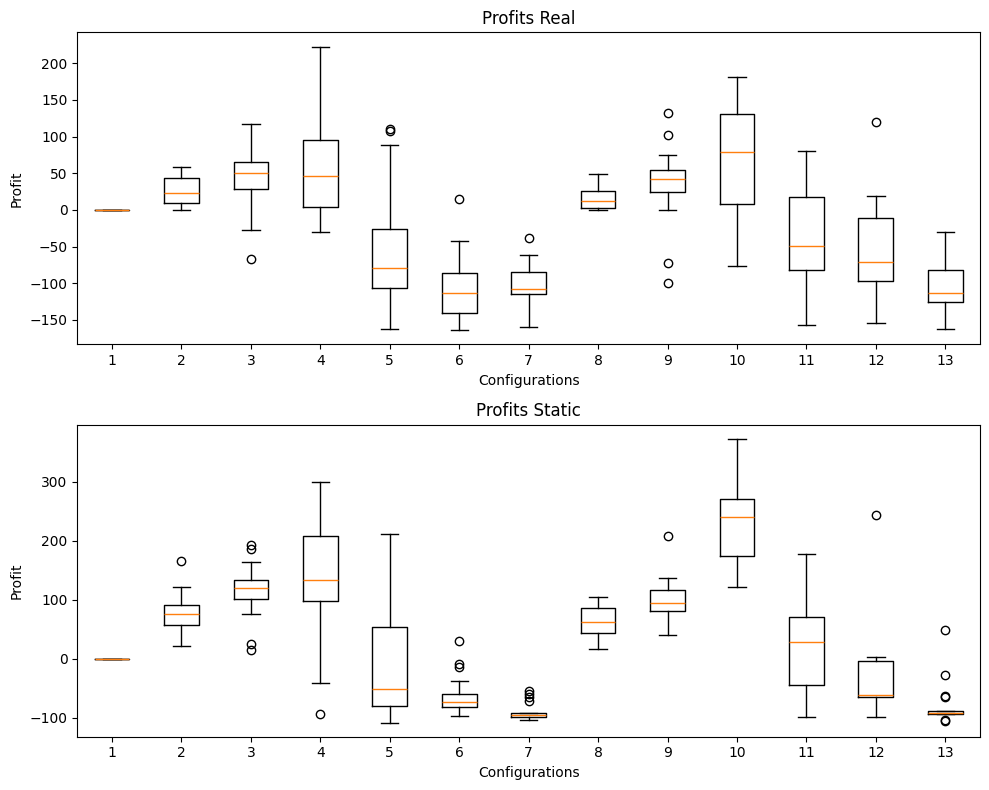

In [26]:
import pandas as pd
import ast
results = pd.read_csv('data/experiment.csv')
data1 = results['profits_real']
data2 = results['profits_static']
def parse_and_convert_to_float(x):
    """解析字符串格式的列表，并将所有元素转换为 float"""
    if isinstance(x, str):
        parsed = ast.literal_eval(x) 
        return [float(item) for item in parsed]
    
data1 = results['profits_real'].apply(parse_and_convert_to_float)
data2 = results['profits_static'].apply(parse_and_convert_to_float)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 8))
ax1.boxplot(data1)
ax1.set_title('Profits Real')
ax1.set_xlabel('Configurations')
ax1.set_ylabel('Profit')

ax2.boxplot(data2)
ax2.set_title('Profits Static')
ax2.set_xlabel('Configurations')
ax2.set_ylabel('Profit')
plt.tight_layout()
plt.show()

Configuration 10最好


## 实验总结

### 最终选择的MMM01*配置

基于上述实验和统计分析,我们选择的MMM01*配置为:

**参数值**:
- `n_past_trades`: [待实验结果]
- `bid_percent`: [待实验结果]  
- `ask_delta`: [待实验结果]

**选择理由**:
1. 该配置在两种市场条件下都表现出色
2. 统计检验显示该配置显著优于默认配置
3. 该配置具有较好的稳健性(标准差较小)

### 实验配置说明

**市场配置1 (静态市场)**:
- 不使用真实定价数据
- 固定供需曲线,均衡价格约150
- 包含ZIP、ZIC、SHVR三种交易者类型,每种5个
- **选择理由**: 提供一个稳定的基准环境,便于观察参数对利润的直接影响

**市场配置2 (真实数据市场)**:
- 使用IBM真实定价数据作为offset
- 动态供需曲线
- 包含ZIP、ZIC、SHVR三种交易者类型,每种5个
- **选择理由**: 模拟真实市场环境,测试参数在动态市场中的表现

**模拟长度**: 600秒(10分钟)
- **选择理由**: 平衡计算时间和数据充分性,足够MMM01进行多次买卖循环

**IID运行次数**: N=30
- **选择理由**: 满足统计检验的样本量要求,能够进行可靠的假设检验
